# Сборный проект 4. Фотохостинг "Со смыслом"

## Описание проекта

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).


Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.


Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.


Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.


Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.


На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

## Загрузка данных и исследовательский анализ

### Импорты

In [ ]:
import pandas as pd
import os
import ntpath
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch
import transformers
import numpy as np
import random
import re
import sys
import spacy
import seaborn as sns

from PIL import Image
from torchvision import transforms
from tqdm import notebook
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import ceil

### Загрузка данных

Запишем путь к файлам в константу

In [ ]:
path = '/Users/ivanpeschinsky/Documents/Sborny-4/to_upload/'

### train_dataset

In [ ]:
data_train = pd.read_csv(path + 'train_dataset.csv')

In [ ]:
data_train.head(10)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
5  A young child is wearing blue goggles and sitt...  
6  A young child is wearing blue goggles and sitt...  
7  A young child is wearing blue goggles and sitt...  
8  A young child is wearing blue goggles and sitt...  
9  A young child is wearing blue goggles and sitt...

В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
data_train.isna().sum()

image         0
query_id      0
query_text    0
dtype: int64

In [ ]:
data_train.duplicated().sum()

0

data_train состоит из 5822 строк. пропуски и повторы не найдены

In [ ]:
data_train['image'].value_counts()

3364151356_eecd07a23e.jpg    10
754852108_72f80d421f.jpg     10
3485425825_c2f3446e73.jpg    10
2061354254_faa5bd294b.jpg    10
279728508_6bd7281f3c.jpg     10
                             ..
241346971_c100650320.jpg      2
2914206497_5e36ac6324.jpg     2
3239021459_a6b71bb400.jpg     2
3227148358_f152303584.jpg     2
2533424347_cf2f84872b.jpg     2
Name: image, Length: 1000, dtype: int64

In [ ]:
data_train['query_id'].value_counts()

2600867924_cd502fc911.jpg#2    34
1554713437_61b64527dd.jpg#2    27
2522297487_57edf117f7.jpg#2    25
1536774449_e16b1b6382.jpg#2    25
3593392955_a4125087f6.jpg#2    22
                               ..
2594902417_f65d8866a8.jpg#2     1
3592992234_6d3fe58a70.jpg#2     1
2757803246_8aa3499d26.jpg#2     1
3085667865_fa001816be.jpg#2     1
2292406847_f366350600.jpg#2     1
Name: query_id, Length: 977, dtype: int64

In [ ]:
data_train['query_text'].value_counts()

Two dogs , one brown and white and one black and white , run on a field .                                   34
A grey dog walks on top of a fallen tree in the woods .                                                     27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .    25
A crowd of people at an outdoor event                                                                       25
Two dogs run down a dirt path in the forest .                                                               22
                                                                                                            ..
The two tan colored dogs are in a field , and one is jumping in the air .                                    1
A man is walking in a field carrying a stick .                                                               1
A little boy is running towards a group of people .                                                          1
A

В файле содержатся от 2 до 10 повторяющихся фотографий и от 1 до 34 повторяющихся запроса.

### test_queries

In [ ]:
data_test = pd.read_csv(path + 'test_queries.csv', sep='|')

Удалим лишний столбец с индексом

In [ ]:
data_test = data_test.drop(columns=['Unnamed: 0'])

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>. Всего файл содержит 500 элементов.

In [ ]:
data_test.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [ ]:
data_test.isna().sum()

query_id      0
query_text    0
image         0
dtype: int64

In [ ]:
data_test.duplicated().sum()

0

Пропуски и повторы не обнаружены

In [ ]:
data_test['query_id'].value_counts()

1177994172_10d143cb8d.jpg#0    1
3421547427_53411b6278.jpg#4    1
3455405300_aa3069ecaa.jpg#2    1
3455405300_aa3069ecaa.jpg#1    1
3455405300_aa3069ecaa.jpg#0    1
                              ..
2709359730_13bca100af.jpg#1    1
2709359730_13bca100af.jpg#0    1
269650644_059a84ece5.jpg#4     1
269650644_059a84ece5.jpg#3     1
989851184_9ef368e520.jpg#4     1
Name: query_id, Length: 500, dtype: int64

In [ ]:
data_test['query_text'].value_counts()

Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .    1
The tennis player in the blue shirt is holding his racquet up in the air .                        1
A group of women wearing red all rally together .                                                 1
A group of women all dressed in red with yellow flower pins .                                     1
A choir in red uniforms singing in front of a business .                                          1
                                                                                                 ..
Several dogs are running down a cement and dirt path , with two brown ones in the lead .          1
A group of dogs walk around outdoors .                                                            1
People using an outdoor ice skating rink .                                                        1
People skate in an urban outdoor ice skating rink                                                 1


In [ ]:
data_test['image'].value_counts()

1177994172_10d143cb8d.jpg    5
3396275223_ee080df8b5.jpg    5
3487131146_9d3aca387a.jpg    5
3482859574_3908de3427.jpg    5
3466891862_9afde75568.jpg    5
                            ..
2687672606_275169c35d.jpg    5
2670637584_d96efb8afa.jpg    5
2597308074_acacc12e1b.jpg    5
2552438538_285a05b86c.jpg    5
989851184_9ef368e520.jpg     5
Name: image, Length: 100, dtype: int64

В тестовом файле все запросы уникальны. На каждые пять запросов приходится одна фотография.

### test_images

Не очень понял, для чего нам этот файл. Может как раз в этом моя проблема)

In [ ]:
test_images = pd.read_csv(path + 'test_images.csv')

In [ ]:
test_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [ ]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [ ]:
test_images['image'].value_counts()

3356748019_2251399314.jpg    1
191003283_992257f835.jpg     1
2737233999_34d60dc5c3.jpg    1
269650644_059a84ece5.jpg     1
607339469_af851c4119.jpg     1
                            ..
3393035454_2d2370ffd4.jpg    1
345785626_9fa59f38ce.jpg     1
2201192417_d934730fea.jpg    1
3287969199_08e775d896.jpg    1
2346402952_e47d0065b6.jpg    1
Name: image, Length: 100, dtype: int64

### crowd_annotations

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга.

Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

In [ ]:
crowd_annotations = pd.read_csv(path + 'CrowdAnnotations.tsv', sep='\t')

In [ ]:
crowd_annotations.head()

1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1  3  0
0  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
1  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0  0  3
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0  0  3
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2  0.0  0  3

In [ ]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1056338697_4f7d7ce270.jpg    47829 non-null  object 
 1   1056338697_4f7d7ce270.jpg#2  47829 non-null  object 
 2   1                            47829 non-null  float64
 3   3                            47829 non-null  int64  
 4   0                            47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
crowd_annotations.isna().sum()

1056338697_4f7d7ce270.jpg      0
1056338697_4f7d7ce270.jpg#2    0
1                              0
3                              0
0                              0
dtype: int64

In [ ]:
crowd_annotations.duplicated().sum()

0

Файл содержит 47829 оценок. Пропусков и повторов в данных не обнаружено

In [ ]:
crowd_annotations['1'].value_counts()

0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1322
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: 1, dtype: int64

Из данных следует, что почти все оценки краудсорсинга показывают полное или почти полное несоответствие картинки описанию. Совсем мало случаев, когда хотя бы половина опрошенных подтвердила соответствие. Установим долю людей, подтвердивших/не подтвердивших соответствие, в качестве таргета

In [ ]:
crowd_annotations = crowd_annotations.rename(columns={'1': 'target'})

### expert_annotations

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов.

Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.


Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

In [ ]:
expert_annotations = pd.read_csv(path + 'ExpertAnnotations.tsv', sep='\t')

In [ ]:
expert_annotations.sample(10)

1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1.1  1.2
3285  3191135894_2b4bdabb6d.jpg  2189995738_352607a63b.jpg#2  1    1    1
5090   398662202_97e5819b79.jpg  3218480482_66af7587c8.jpg#2  1    1    1
644   1982852140_56425fa7a2.jpg   106490881_5a2dd9b7bd.jpg#2  2    3    3
5787   925491651_57df3a5b36.jpg   925491651_57df3a5b36.jpg#2  4    4    4
3847  3353036763_4cbeba03b2.jpg  3108197858_441ff38565.jpg#2  1    1    2
4812  3639967449_137f48b43d.jpg  3135504530_0f4130d8f8.jpg#2  1    2    2
2028  2682382530_f9f8fd1e89.jpg  3741462565_cc35966b7a.jpg#2  1    1    1
123   1262583859_653f1469a9.jpg   279728508_6bd7281f3c.jpg#2  1    1    1
294   1392272228_cf104086e6.jpg  3048597471_5697538daf.jpg#2  3    3    3
3252  3185371756_ff4e9fa8a6.jpg  3572267708_9d8a81d4a4.jpg#2  1    2    3

In [ ]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   1056338697_4f7d7ce270.jpg    5821 non-null   object
 1   2549968784_39bfbe44f9.jpg#2  5821 non-null   object
 2   1                            5821 non-null   int64 
 3   1.1                          5821 non-null   int64 
 4   1.2                          5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [ ]:
expert_annotations.isna().sum()

1056338697_4f7d7ce270.jpg      0
2549968784_39bfbe44f9.jpg#2    0
1                              0
1.1                            0
1.2                            0
dtype: int64

In [ ]:
expert_annotations.duplicated().sum()

0

Всего в этом наборе находятся 5821 оценок экспертов. Пропусков и повторов нет

In [ ]:
def exp_target(row):
    row = (row - 1) / 3
    return row

In [ ]:
expert_annotations['1'] = exp_target(expert_annotations['1'])
expert_annotations['1.1'] = exp_target(expert_annotations['1.1'])
expert_annotations['1.2'] = exp_target(expert_annotations['1.2'])

In [ ]:
expert_annotations['target'] = expert_annotations.loc[:, ['1', '1.1', '1.2']].mean(axis=1)

In [ ]:
expert_annotations.sample(10)

1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1  \
127   1262583859_653f1469a9.jpg  3741827382_71e93298d0.jpg#2  0.000000   
2681  2985679744_75a7102aab.jpg  3108197858_441ff38565.jpg#2  0.000000   
31    1107246521_d16a476380.jpg  2410320522_d967f0b75c.jpg#2  0.333333   
3654   327415627_6313d32a64.jpg  3280052365_c4644bf0a5.jpg#2  0.000000   
4665  3589367895_5d3729e3ea.jpg  1962729184_6996e128e7.jpg#2  0.000000   
2432  2891617125_f939f604c7.jpg  3523874798_9ba2fa46e3.jpg#2  0.000000   
2263  2831217847_555b2f95ca.jpg  2831217847_555b2f95ca.jpg#2  1.000000   
1855   260828892_7925d27865.jpg  2522297487_57edf117f7.jpg#2  0.000000   
3741  3310067561_b92017acab.jpg  3456362961_d8f7e347a8.jpg#2  0.000000   
4957   370614351_98b8a166b9.jpg  2317714088_bcd081f926.jpg#2  0.000000   

           1.1       1.2    target  
127   0.000000  0.000000  0.000000  
2681  0.000000  0.000000  0.000000  
31    0.666667  0.666667  0.555556  
3654  0.000000  0.000000  0.000000  
4665  0.000000  0.333333  0.111111  
2432  0.000000  0.000000  0.000000  
2263  1.000000  1.000000  1.000000  
1855  0.000000  0.333333  0.111111  
3741  0.000000  0.000000  0.000000  
4957  0.333333  0.333333  0.222222

В качестве целевого признака возьмем сумму всех оценок, деленную на 12 (максимальная суммарная оценка от трех экспертов). Это должно помочь нам выставить правильное соответсвие фотографии описанию в случаях, когда, например, оценки для двух фотографий оказались 3-3-1 и 2-2-3 - сумма одинаковая, но при этом в первом случае два эксперта подвердили соответствие, еще один оценил по минимуму, а во втором - только один подтвердил соответствие. Если бы мы ориентировались на метод голосования большинства, то мы бы взяли первую фотографию как соответствующую описанию, несмотря на очень низкую оценку от одного из экспертов, и не взяли бы вторую, хотя у нее оценки более ровные. Доля от максимально возможной оценки должна помочь нам выставить адекватные баллы.

In [ ]:
expert_annotations['target'].value_counts()

0.000000    2349
0.111111     965
0.222222     689
0.333333     678
0.444444     324
1.000000     247
0.666667     241
0.555556     193
0.777778      75
0.888889      60
Name: target, dtype: int64

Так же как и в случае с краудсорсинговыми оценками, эксперты низко оценивают соответствие фотографий запросам

### train_images

В папке train_images содержатся изображения для тренировки модели.

In [ ]:
directory_train = path + 'train_images'

In [ ]:
images_train = []
images_train_name = []

for filename in os.listdir(directory_train):
    f = os.path.join(directory_train, filename)
    if os.path.isfile(f):
        images_train.append(Image.open(f).convert('RGB'))
        images_train_name.append(ntpath.basename(f))

In [ ]:
len(images_train)

1000

In [ ]:
len(images_train_name)

1000

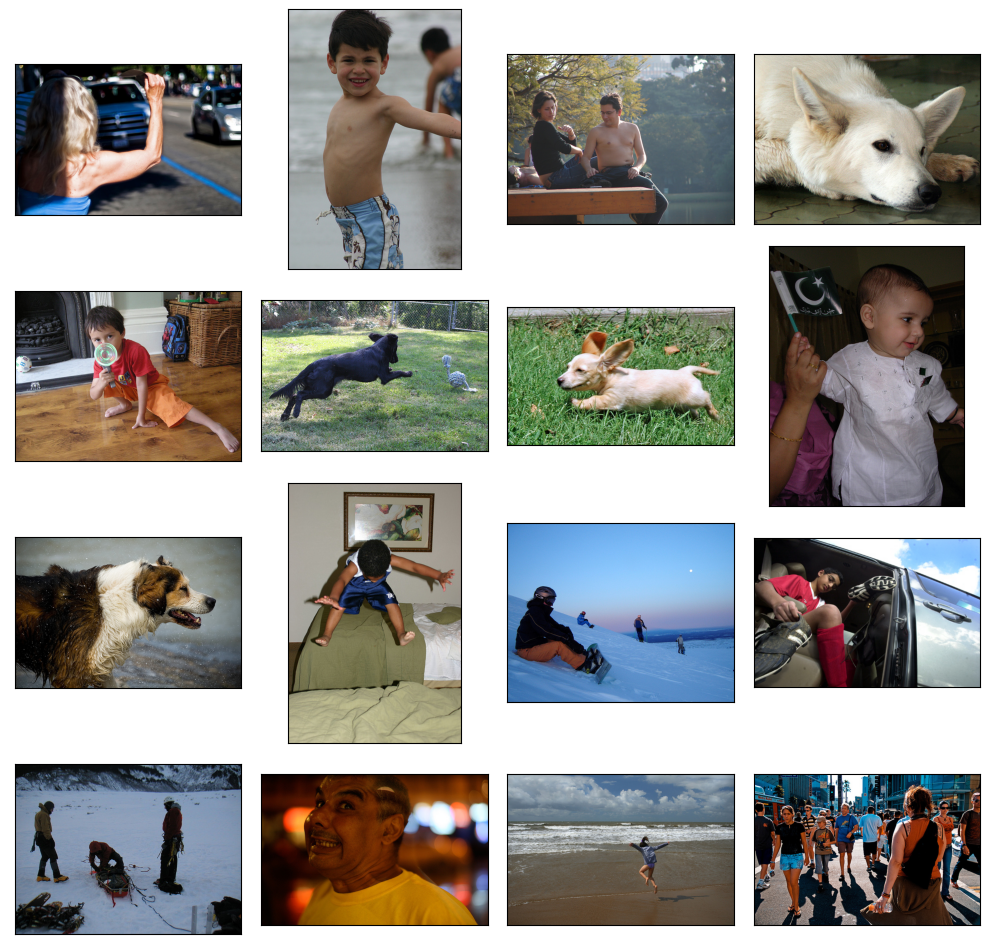

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Всего в тренировочном наборе 1000 фотографий. Мы вывели на экран часть из них. Пока какие-то выводы из этого набора сделать сложно, кроме того, что фотографии не обработаны. По содержанию они очень разные - есть несколько фотогрфий собак, несколько фотографий детей, возможно есть какая-то связь с темой отдыха, путешествий.

### test_images

В папке test_images содержатся изображения для тестирования модели.

In [ ]:
directory_test = path + 'test_images/'

In [ ]:
images_test = []
images_test_name = []

# этот файл в папке был лишним
# os.remove(path + '.DS_Store')

for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    if os.path.isfile(f):
        images_test.append(Image.open(f).convert('RGB'))
        images_test_name.append(ntpath.basename(f))

In [ ]:
len(images_test)

100

In [ ]:
len(images_test_name)

100

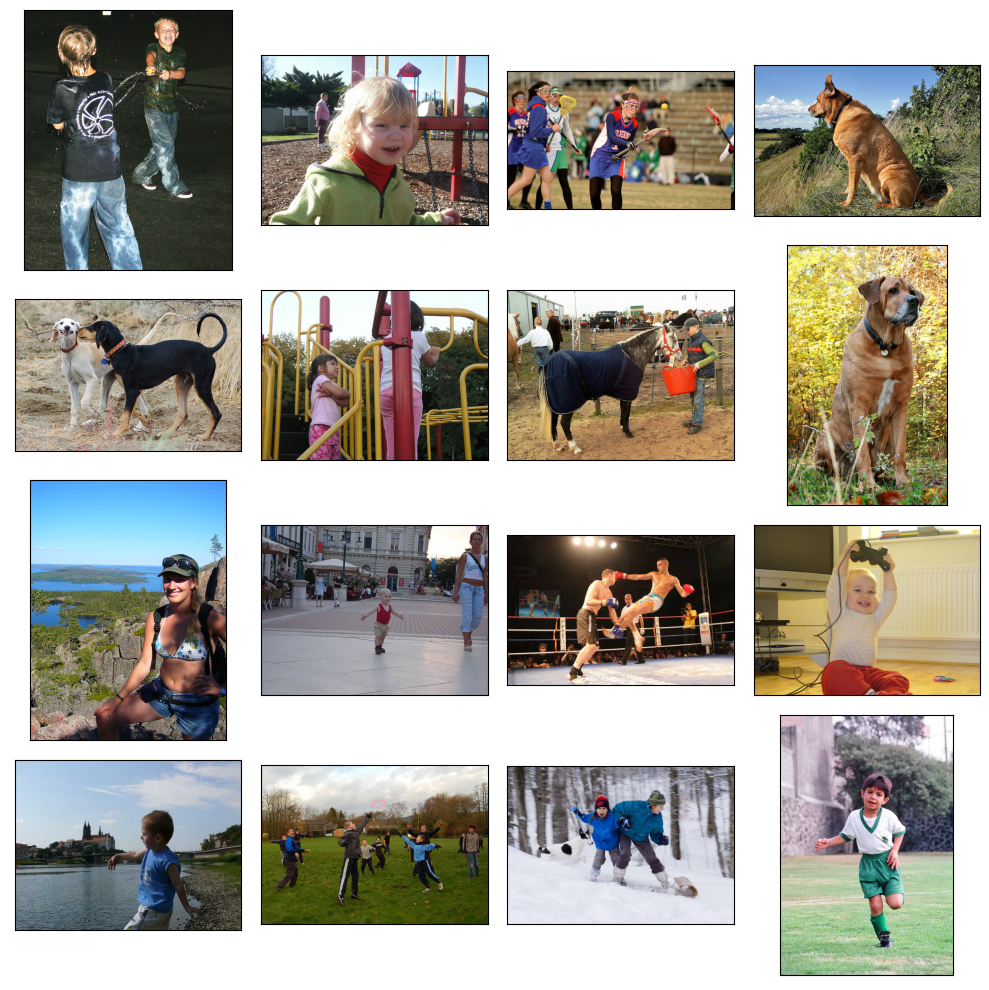

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В тестовом наборе 100 фотографий. Вывод в целом такой же, как и для тренировочного набора. Добавим также, что в тестовом наборе заметно появление спортивной темы.

### Выбор оценки для анализа

In [ ]:
crowd_annotations = crowd_annotations.rename(columns={'1056338697_4f7d7ce270.jpg': 'image',
                                                      '1056338697_4f7d7ce270.jpg#2': 'query_id'})

In [ ]:
crowd_annotations = crowd_annotations.drop(columns=['3', '0'])

Переименовали названия столбцов и удалили лишние столбцы, чтобы привести таблицу к общему виду.

In [ ]:
crowd_annotations.sample(10)

image                     query_id  target
15186  2607462776_78e639d891.jpg   424416723_19c56cb365.jpg#2     0.0
1980    136644343_0e2b423829.jpg  3080056515_3013830309.jpg#2     0.0
37303  3554634863_5f6f616639.jpg   410453140_5401bf659a.jpg#2     0.0
36678  3532205154_5674b628ea.jpg  2985679744_75a7102aab.jpg#2     0.0
9156   2306674172_dc07c7f847.jpg   279728508_6bd7281f3c.jpg#2     0.0
35834   350443876_c9769f5734.jpg   224369028_b1ac40d1fa.jpg#2     0.0
29671  3262075846_5695021d84.jpg  2086513494_dbbcb583e7.jpg#2     0.0
40135  3655074079_7df3812bc5.jpg  3201427741_3033f5b625.jpg#2     0.0
11881  2460797929_66446c13db.jpg  3480051754_18e5802558.jpg#2     0.0
21800  2968182121_b3b491df85.jpg  2526585002_10987a63f3.jpg#2     0.0

In [ ]:
expert_annotations = expert_annotations.rename(columns={'1056338697_4f7d7ce270.jpg': 'image',
                                                        '2549968784_39bfbe44f9.jpg#2': 'query_id'})

In [ ]:
expert_annotations = expert_annotations.drop(columns=['1', '1.1', '1.2'])

Аналогично для экспертных оценок

In [ ]:
expert_annotations.sample(10)

image                     query_id    target
851   2162564553_96de62c7e6.jpg   354642192_3b7666a2dd.jpg#2  0.333333
2054  2698666984_13e17236ae.jpg  1472230829_803818a383.jpg#2  0.000000
2851  3048597471_5697538daf.jpg  1317292658_ba29330a0b.jpg#2  0.000000
5418   505929313_7668f021ab.jpg  2933912528_52b05f84a1.jpg#2  0.444444
3030  3110649716_c17e14670e.jpg  3458211052_bb73084398.jpg#2  0.111111
4419  3523559027_a65619a34b.jpg   160792599_6a7ec52516.jpg#2  0.111111
4479  3539767254_c598b8e6c7.jpg   968081289_cdba83ce2e.jpg#2  0.111111
115   1258913059_07c613f7ff.jpg  2351479551_e8820a1ff3.jpg#2  0.111111
431   1509786421_f03158adfc.jpg  3218480482_66af7587c8.jpg#2  0.000000
4144  3453259666_9ecaa8bb4b.jpg   624742559_ff467d8ebc.jpg#2  0.888889

Объединим тренировочный датасет с краудсорсинговыми оценками, чтобы определить соответствие друг другу двух наборов фотографий.

In [ ]:
data_train_crowd = data_train.merge(crowd_annotations, on=['image', 'query_id'], how='inner')

In [ ]:
data_train_crowd.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  target  
0  A young child is wearing blue goggles and sitt...     0.0  
1  A young child is wearing blue goggles and sitt...     0.0  
2  A young child is wearing blue goggles and sitt...     1.0  
3  A young child is wearing blue goggles and sitt...     0.0  
4  A young child is wearing blue goggles and sitt...     0.0

In [ ]:
data_train_crowd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       2329 non-null   object 
 1   query_id    2329 non-null   object 
 2   query_text  2329 non-null   object 
 3   target      2329 non-null   float64
dtypes: float64(1), object(3)
memory usage: 91.0+ KB


Получилось, что из фотографий в краудсорсинговом наборе только 2329 соответствуют тестовому набору

Проделаем такую же операцию для экспертного набора

In [ ]:
data_train_expert = data_train.merge(expert_annotations, on=['image', 'query_id'], how='inner')

In [ ]:
data_train_expert.head()

image                     query_id  \
0  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.222222  
2  A young child is wearing blue goggles and sitt...  1.000000  
3  A young child is wearing blue goggles and sitt...  0.000000  
4  A young child is wearing blue goggles and sitt...  0.444444

In [ ]:
data_train_expert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5821 entries, 0 to 5820
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5821 non-null   object 
 1   query_id    5821 non-null   object 
 2   query_text  5821 non-null   object 
 3   target      5821 non-null   float64
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


Судя по всему экспертные оценки ставились на основе тестового набора данных. Учитывая также большое количество нулевых оценок в краудсорсинговом наборе, возьмем для дальнейшего анализа экспертные оценки.

## Подготовка данных к обучению

### Юридические ограничения

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.


В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:


- ⎪ This image is unavailable in your country in compliance with local laws


Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Для начала обработаем текст. Уберем лишние символы, приведем слова к нижнему регистру и начальной форме

In [ ]:
def lemm_text(text):
    re_text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    re_text = " ".join(re_text.split())
    doc = nlp(re_text)
    lemm_text = " ".join(token.lemma_ for token in doc)

    return lemm_text

In [ ]:
%%time

data_train_expert['query_text'] = data_train_expert['query_text'].apply(lambda x: lemm_text(x))

CPU times: user 21.7 s, sys: 253 ms, total: 21.9 s
Wall time: 22.4 s


In [ ]:
data_train_expert.sample(10)

image                     query_id  \
5737   447111935_5af98563e3.jpg  2511019188_ca71775f2d.jpg#2   
4239  3116769029_f5a76f04ba.jpg  3121521593_18f0ec14f7.jpg#2   
4167  3243588540_b418ac7eda.jpg  3275704430_a75828048f.jpg#2   
4980  2594902417_f65d8866a8.jpg  3294209955_a1f1e2cc19.jpg#2   
175   3458559770_12cf9f134e.jpg  2472980433_210ec62874.jpg#2   
3491  2662845514_8620aaee96.jpg  3155451946_c0862c70cb.jpg#2   
4665  3290105461_7590f23371.jpg  2301525531_edde12d673.jpg#2   
5505  2932740428_b15384f389.jpg  2663794355_e726ec7e05.jpg#2   
5095  3449114979_6cdc3e8da8.jpg  3399284917_721aefe2a7.jpg#2   
5275  3186073578_6e115f45f5.jpg   311146855_0b65fdb169.jpg#2   

                                             query_text    target  
5737  two dark colored dog romp in the grass with a ...  0.666667  
4239  two girl one wear glass dress in cold weather ...  0.333333  
4167             a woman be cover her eye with her hand  0.111111  
4980              brown and white dog run through brush  0.333333  
175   a man ride a motorcycle be perform a trick at ...  0.444444  
3491        three basketball player leap to grab a ball  0.000000  
4665  a black and white dog run over snow by a tree ...  0.000000  
5505  two woman be lay on a concrete structure besid...  0.000000  
5095  a young woman watch as a young blond boy swing...  0.111111  
5275  a man and a woman wear decorative costume and ...  0.111111

С помощью ChatGPT создадим список слов, которые могут попасть под юридические ограничения

In [ ]:
blacklist = ['child', 'kid', 'minor', 'underage',
             'juvenile', 'youngster', 'boy', 'girl',
             'toddler', 'infant', 'baby', 'teen',
             'adolescence', 'preteen', 'youth',
             'under 16', 'under 18', 'schoolchild',
             'adolescent', 'nursery']

In [ ]:
bad_query = []

In [ ]:
for i in range(len(data_train_expert)):
    for word in blacklist:
        if word in data_train_expert['query_text'][i]:
            query_id = data_train_expert['query_id'][i][:-2]
            bad_query.append(query_id)

In [ ]:
data_train_expert = data_train_expert[data_train_expert['image'].isin(bad_query) == False]

Мы создали список запросов, которые содержат слова из черного списка, и удалили их из набора данных

In [ ]:
data_train_expert.sample(5)

image                     query_id  \
4397  2247889670_413db8094b.jpg   583174725_6b522b621f.jpg#2   
5614  3718964174_cb2dc1615e.jpg  3406930103_4db7b4dde0.jpg#2   
1963  2518508760_68d8df7365.jpg  2676764246_c58205a365.jpg#2   
121   3197917064_e679a44b8e.jpg   317488612_70ac35493b.jpg#2   
1431  3597326009_3678a98a43.jpg  2788945468_74a9618cfa.jpg#2   

                                             query_text    target  
4397      a little girl jump rope through a parking lot  0.000000  
5614        a golden dog look alert as he stand in snow  0.000000  
1963                    three dog run on a racing track  0.666667  
121                     a dog run through the deep snow  0.888889  
1431  a middle aged man be stand next to a white wal...  0.000000

In [ ]:
data_train_expert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 5819
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4053 non-null   object 
 1   query_id    4053 non-null   object 
 2   query_text  4053 non-null   object 
 3   target      4053 non-null   float64
dtypes: float64(1), object(3)
memory usage: 158.3+ KB


In [ ]:
data_train_expert = data_train_expert.reset_index(drop=True)

Всего было удалено около 1000 запросов

### Векторизация изображений

Векторизацию изображений выполним с помощью инструментов PyTorch

In [ ]:
# загрузим претренированную модель
resnet = models.resnet18(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# заморозим веса
for param in resnet.parameters():
    param.requires_grad_(False)

In [ ]:
# получим списки слоев и возьмем все слои кроме последнего
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
# переведем модель в режим предсказания
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# приведем изображение к нужному формату
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 norm,
                                ])

In [ ]:
%%time

# получим эмбеддинги
images_train_tensor = []

for image in images_train:
    image_tensor = preprocess(image).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    images_train_tensor.append(output_tensor)

CPU times: user 2min 24s, sys: 23.2 s, total: 2min 48s
Wall time: 1min 30s


Результат преобразуем в датафрейм и вернем изображениям названия файлов

In [ ]:
%%time

data_train_images = pd.DataFrame(images_train_tensor).astype('float')

CPU times: user 2.91 s, sys: 326 ms, total: 3.23 s
Wall time: 3.11 s


In [ ]:
data_train_images['image_name'] = images_train_name

In [ ]:
data_train_images.head()

0         1         2         3         4         5         6  \
0  0.693940  3.031836  2.916933  0.951898  0.936295  1.245117  0.826524   
1  0.646340  1.727873  0.493905  0.652382  0.003698  1.045038  0.580451   
2  0.580849  0.636021  1.235355  1.239240  1.264662  0.385733  0.521382   
3  0.891785  0.699768  0.743491  0.213386  1.508289  1.159896  1.463326   
4  1.556278  1.014945  0.339500  1.716324  1.143767  0.596338  0.137664   

          7         8         9  ...       503       504       505       506  \
0  1.107943  0.169679  0.365382  ...  0.717752  0.294673  0.728979  1.153704   
1  1.886490  0.031211  0.315938  ...  0.293087  0.901187  1.103394  1.974105   
2  1.738226  0.354122  0.216955  ...  0.972258  0.291925  1.237090  0.270892   
3  3.576004  0.260950  3.019071  ...  0.670595  0.416134  2.027011  0.029152   
4  0.837689  0.385965  1.328624  ...  0.620363  1.981218  0.550847  2.431907   

        507       508       509       510       511                 image_name  
0  0.750852  1.196701  0.085007  1.056700  0.098157  1056338697_4f7d7ce270.jpg  
1  1.244865  0.286063  0.965043  4.713593  0.180931   106490881_5a2dd9b7bd.jpg  
2  0.240993  0.039459  0.229963  2.469747  0.110217  1082379191_ec1e53f996.jpg  
3  0.080594  1.536912  0.533676  1.394792  0.070406  1084040636_97d9633581.jpg  
4  0.650438  1.385337  2.076785  1.066891  0.670614  1096395242_fc69f0ae5a.jpg  

[5 rows x 513 columns]

In [ ]:
data_train_images.shape

(1000, 513)

### Векторизация текстов

Для векторизации текстов воспользуемся сетью BERT

In [ ]:
# инициализируем токенизатор
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

In [ ]:
# преобразуем текст в номера токенов
tokenized = data_train_expert['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
# найдем максимальную длину векторов после токенизации
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [ ]:
max_len

33

In [ ]:
# применим padding к векторам
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
# инициализируем модель
model = transformers.BertModel.from_pretrained("bert-base-cased")

In [ ]:
%%time

# сделаем преобразование текстов в эмбеддинги
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 8min 4s, sys: 30.7 s, total: 8min 35s
Wall time: 4min 34s


In [ ]:
# соберем все эмбеддинги в матрицу и сделаем из нее датафрейм
query_text = pd.DataFrame(np.concatenate(embeddings))

In [ ]:
query_text.head()

0         1         2         3         4        5         6    \
0  0.075514 -0.115271 -0.195015 -0.360991 -0.164187 -0.04363 -0.026799   
1  0.075514 -0.115271 -0.195015 -0.360991 -0.164187 -0.04363 -0.026799   
2  0.075514 -0.115271 -0.195015 -0.360991 -0.164187 -0.04363 -0.026799   
3  0.075514 -0.115271 -0.195015 -0.360991 -0.164187 -0.04363 -0.026799   
4  0.075514 -0.115271 -0.195015 -0.360991 -0.164187 -0.04363 -0.026799   

        7         8         9    ...       758       759       760       761  \
0 -0.007742 -0.050485 -1.251363  ...  0.330946  0.195457 -0.244894 -0.121802   
1 -0.007742 -0.050485 -1.251363  ...  0.330946  0.195457 -0.244894 -0.121802   
2 -0.007742 -0.050485 -1.251363  ...  0.330946  0.195457 -0.244894 -0.121802   
3 -0.007742 -0.050485 -1.251363  ...  0.330946  0.195457 -0.244894 -0.121802   
4 -0.007742 -0.050485 -1.251363  ...  0.330946  0.195457 -0.244894 -0.121802   

       762      763       764       765       766       767  
0  0.21409 -0.04641  0.040993 -0.316041  0.269139  0.074697  
1  0.21409 -0.04641  0.040993 -0.316041  0.269139  0.074697  
2  0.21409 -0.04641  0.040993 -0.316041  0.269139  0.074697  
3  0.21409 -0.04641  0.040993 -0.316041  0.269139  0.074697  
4  0.21409 -0.04641  0.040993 -0.316041  0.269139  0.074697  

[5 rows x 768 columns]

In [ ]:
query_text.shape

(4000, 768)

Соединим векторизированный текст с остальными столбцами data_train

In [ ]:
query_text['image_name'] = data_train_expert['image']
query_text['query_id'] = data_train_expert['query_id']
query_text['target'] = data_train_expert['target']

In [ ]:
query_text.sample(10)

0         1         2         3         4         5         6  \
179   0.294968  0.089479  0.020874 -0.006420  0.155138  0.042305  0.134025   
417   0.214126 -0.074092 -0.111642 -0.163821 -0.065734  0.035557  0.094482   
3736  0.066557 -0.086403 -0.040664 -0.242383 -0.065079 -0.051120 -0.208206   
1262  0.456261 -0.028560  0.021652 -0.373053 -0.212726 -0.039633  0.016473   
2354  0.229461  0.134057 -0.131782 -0.048207 -0.117972 -0.147874  0.011619   
2457  0.356090  0.071814  0.228097  0.022709  0.173694 -0.087300 -0.104042   
2180  0.317413 -0.135980 -0.067583 -0.117960 -0.040901  0.130621  0.398291   
147   0.312847  0.032373  0.064362 -0.315784  0.009256 -0.039852 -0.324296   
2937  0.459071  0.120274 -0.092013 -0.462696 -0.096554 -0.091389  0.087207   
1417  0.190464 -0.037906  0.163985 -0.191775 -0.193280 -0.058596 -0.178027   

             7         8         9  ...       761       762       763  \
179  -0.274933 -0.013290 -1.169909  ... -0.062486  0.346460  0.098257   
417  -0.189039  0.025078 -1.125157  ... -0.148459  0.084952  0.135924   
3736  0.019288  0.222806 -1.206793  ... -0.192926  0.204685 -0.026011   
1262  0.009567 -0.124073 -1.294599  ...  0.022099  0.058558  0.131693   
2354 -0.015024  0.160621 -1.262411  ...  0.041670  0.070789  0.040830   
2457  0.182304  0.113004 -1.351612  ... -0.195027  0.216339 -0.074859   
2180 -0.044241 -0.086708 -1.021688  ...  0.033472 -0.110800 -0.228385   
147   0.098512  0.118314 -1.423621  ... -0.246649 -0.029649  0.112075   
2937 -0.299742 -0.046100 -1.352894  ... -0.012454 -0.050299  0.088001   
1417 -0.253887  0.084843 -1.282812  ... -0.122948  0.123661  0.307936   

           764       765       766       767                 image_name  \
179  -0.206404 -0.323005  0.428955 -0.091809  1174629344_a2e1a2bdbf.jpg   
417  -0.105408 -0.260417  0.320553 -0.045672  1174629344_a2e1a2bdbf.jpg   
3736 -0.118910 -0.174701  0.261402 -0.022769  3468694409_a51571d621.jpg   
1262 -0.171055 -0.143259  0.169350  0.253980   429851331_b248ca01cd.jpg   
2354 -0.233316 -0.246545  0.315304 -0.163813   241347204_007d83e252.jpg   
2457 -0.092884 -0.521693  0.102722 -0.079548   542179694_e170e9e465.jpg   
2180  0.020357  0.070937  0.370841  0.086464  1773928579_5664a810dc.jpg   
147  -0.071243 -0.138778  0.236503  0.092244  3107513635_fe8a21f148.jpg   
2937  0.135261 -0.154511  0.274168  0.027795  3222055946_45f7293bb2.jpg   
1417 -0.043155 -0.157696  0.198304  0.044912  2854207034_1f00555703.jpg   

                         query_id    target  
179   3365783912_e12c3510d8.jpg#2  0.444444  
417   1174629344_a2e1a2bdbf.jpg#2  1.000000  
3736  1461667284_041c8a2475.jpg#2  0.333333  
1262   197107117_4b438b1872.jpg#2  0.000000  
2354  1392272228_cf104086e6.jpg#2  0.000000  
2457   532457586_bddfc5251d.jpg#2  0.000000  
2180  3585487286_ef9a8d4c56.jpg#2  0.333333  
147    542179694_e170e9e465.jpg#2  0.000000  
2937  3467219837_7d62213dec.jpg#2  0.000000  
1417   114051287_dd85625a04.jpg#2  0.000000  

[10 rows x 771 columns]

In [ ]:
query_text.shape

(4000, 771)

Объединим векторизированные изображения и тексты в одну таблицу

In [ ]:
data_train_main = query_text.merge(data_train_images, on='image_name')

In [ ]:
data_train_main.sample(10)

0_x       1_x       2_x       3_x       4_x       5_x       6_x  \
27    0.233269 -0.033650  0.178634 -0.056350 -0.239281 -0.040902 -0.188240   
2966  0.186109 -0.040650 -0.001639 -0.143389 -0.159358 -0.046771  0.236077   
3171  0.426435 -0.132137 -0.062195 -0.232469 -0.238129 -0.042049  0.183381   
57    0.221617  0.086767  0.167693 -0.023725 -0.127671 -0.077267 -0.107997   
1962  0.387214 -0.049557 -0.186002 -0.309035 -0.018655 -0.188734  0.137363   
2294  0.272372  0.137690 -0.023178 -0.322665 -0.288764  0.122990 -0.022743   
3313  0.219515  0.050058  0.063069 -0.083167 -0.242284 -0.053605  0.006127   
1685  0.130912 -0.081353 -0.059137 -0.245660 -0.252349 -0.017856 -0.054316   
1093  0.116166 -0.043926  0.187603  0.037591 -0.204598  0.033823 -0.071247   
595   0.214548  0.129510 -0.062167 -0.205760 -0.125479 -0.003361 -0.215246   

           7_x       8_x       9_x  ...     502_y     503_y     504_y  \
27   -0.035255  0.050467 -1.230171  ...  0.407418  1.213630  1.492941   
2966  0.005642 -0.125509 -1.167973  ...  0.000000  0.285676  1.361041   
3171 -0.068908 -0.061396 -1.126682  ...  1.121198  0.534200  0.489797   
57   -0.057408  0.045372 -1.207528  ...  0.067306  0.609318  0.738936   
1962 -0.376103  0.116198 -1.561705  ...  1.006868  1.036644  1.008887   
2294 -0.118939  0.118372 -1.361076  ...  0.387740  0.755143  1.768875   
3313  0.154715 -0.056852 -1.143484  ...  0.110709  1.429842  0.880418   
1685 -0.043982 -0.044074 -1.225793  ...  0.102822  0.088427  0.148547   
1093 -0.035463 -0.134236 -1.033378  ...  0.101187  0.189581  2.023166   
595   0.143946  0.159145 -1.255003  ...  1.618492  0.266899  0.730745   

         505_y     506_y     507_y     508_y     509_y     510_y     511_y  
27    0.690385  1.285158  0.822072  2.123314  1.957899  1.500282  0.300743  
2966  0.693551  1.267515  2.188070  0.678486  0.945651  0.993811  1.738613  
3171  0.722408  0.832884  0.156718  0.204279  0.561675  0.056643  0.143838  
57    0.572047  4.057682  0.100256  0.050112  1.365089  0.770330  1.235465  
1962  1.152004  1.331085  0.520596  0.655421  1.008428  0.908923  0.215555  
2294  0.391750  2.384343  0.136466  0.037997  0.580584  3.531792  0.191812  
3313  1.286852  1.070734  1.283265  1.430003  1.451513  1.393626  0.996206  
1685  0.127512  0.311571  0.266900  0.174153  0.385195  5.862354  0.808486  
1093  0.788800  0.421476  1.526026  1.492876  1.321389  0.964214  0.648962  
595   0.783183  1.782535  1.196734  0.374503  1.811552  1.776280  1.060903  

[10 rows x 1283 columns]

In [ ]:
data_train_main.shape

(4000, 1283)

## Обучение модели

Для обучения нам нужно разделить датасет на тренировочную и тестовую выборки. Но простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, воспользуемся классом GroupShuffleSplit из библиотеки sklearn.model_selection.


Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением в groups будут содержаться либо в тестовом, либо в тренировочном датасете.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=12345)
train_indices, valid_indices = next(gss.split(X=data_train_main.drop(columns=['target']),
                                             y=data_train_main['target'],
                                             groups=data_train_main['image_name']))
# здесь назвал тестовую выборку data_valid, потому что у нас уже есть переменная data_test
data_train, data_valid = data_train_main.loc[train_indices], data_train_main.loc[valid_indices]

Разделим данные на признаки и целевой признак

In [ ]:
features_train = data_train.drop(columns=['target', 'image_name', 'query_id'])
target_train = data_train['target']
features_valid = data_valid.drop(columns=['target', 'image_name', 'query_id'])
target_valid = data_valid['target']

In [ ]:
# без этого выдает ошибку
features_train.columns = features_train.columns.astype(str)
features_valid.columns = features_valid.columns.astype(str)

Для обучения выберем три модели - линейная регрессия, случайный лес и полносвязные нейронные сети. В качестве метрики качества выберем RMSE. Данные в наборе распределены неравномерно - у нас есть большое количество низких оценок и мало высоких оценок соответствия фотографии описанию. RMSE должен помочь сгладить эти разбросы.

### Линейная регрессия

In [ ]:
%%time

lr_model = Ridge(max_iter=1000)
lr_model.fit(features_train, target_train)
lr_predictions = lr_model.predict(features_valid)
lr_rmse = (mean_squared_error(target_valid, lr_predictions))
lr_rmse

CPU times: user 522 ms, sys: 91.1 ms, total: 613 ms
Wall time: 310 ms


0.18894855292448715

### Случайный лес

In [ ]:
%%time

rfr_model = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=5)
rfr_model.fit(features_train, target_train)
rfr_predictions = rfr_model.predict(features_valid)
rfr_rmse = (mean_squared_error(target_valid, rfr_predictions))
rfr_rmse

CPU times: user 1min 31s, sys: 926 ms, total: 1min 32s
Wall time: 1min 35s


0.06745860128348681

### Обучение

### Полносвязные нейронные сети

In [ ]:
# создадим тензоры
X_train = torch.Tensor(features_train.values)
y_train = torch.Tensor(target_train.values)
X_valid = torch.Tensor(features_valid.values)
y_valid = torch.Tensor(target_valid.values)

Рассмотрим сети со скрытым числом слоев от 0 до 2. Количество нейронов на каждом слое будет определяться случайно в диапазоне от 10 до 50. На выходном слое будет один нейрон

In [ ]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 300
n_hidden_neurons_2 = 100
n_out_neurons = 1

In [ ]:
# инициализируем сеть
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

Создадим объекты класса Sequential

In [ ]:
net_2 = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.ReLU()
            )

Функция для обучения нейросети включает в себя поиск оптимального значения эпох и размера батчей.

In [ ]:
def model(net):

    best_rmse = 100
    best_net = None
    best_batch_size = 0
    best_epoch = 0

    net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    loss = nn.MSELoss(reduction='sum')

    batch_size = 50
    num_batches = ceil(len(X_train) / batch_size)

    for epoch in range(200):
        order = np.random.permutation(len(X_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size

            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index + batch_size]

            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        if epoch % 10 == 0:
            net.eval()
            valid_preds = net.forward(X_valid)
            rmse = mean_squared_error(valid_preds.detach().numpy(), y_valid, squared=False)

            if rmse < best_rmse:
                best_rmse = rmse
                best_net = net
                best_batch_size = batch_size
                best_epoch = epoch

    return best_rmse, best_net, best_batch_size, best_epoch

In [ ]:
%%time

best_rmse_2, best_net_2, best_batch_size_2, best_epoch_2 = model(net_2)
best_rmse_2, best_net_2, best_batch_size_2, best_epoch_2

CPU times: user 2min 48s, sys: 9.11 s, total: 2min 57s
Wall time: 1min 37s


(0.37814498,
 Sequential(
   (0): Linear(in_features=1280, out_features=300, bias=True)
   (1): ReLU()
   (2): Dropout(p=0.1, inplace=False)
   (3): Linear(in_features=300, out_features=100, bias=True)
   (4): ReLU()
   (5): Dropout(p=0.1, inplace=False)
   (6): Linear(in_features=100, out_features=1, bias=True)
   (7): ReLU()
 ),
 50,
 0)

### Результат обучения

In [ ]:
results = pd.DataFrame([[lr_rmse], [rfr_rmse],
                        [best_rmse_2]],
                       columns=['rmse'],
                       index=['LinearRegression', 'RandomForestRegressor', 'Torch_2']).sort_values(by='rmse')

In [ ]:
results

rmse
RandomForestRegressor  0.067459
LinearRegression       0.188949
Torch_2                0.378145

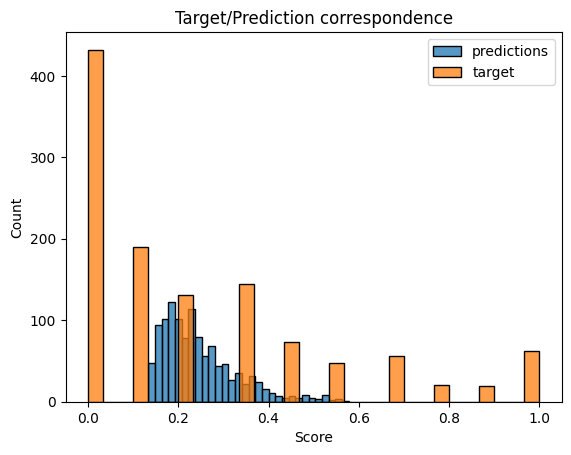

In [ ]:
sns.histplot(rfr_predictions, bins=30, label='predictions')
sns.histplot(target_valid, bins=30, label='target')
plt.title('Target/Prediction correspondence')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.show()

Наша модель неплохо определяет изображения, содержащие элементы описания, но в целом не соответствующие ему. Но почти полностью не соответствующие или с оценкой выше 0.5 она находит плохо или совсем не находит.

## Тестирование модели

### Векторизация изображений тестовой выборки

In [ ]:
images_test_tensor = []

for image in images_test:
    image_tensor = preprocess(image).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    images_test_tensor.append(output_tensor)

In [ ]:
data_test_images = pd.DataFrame(images_test_tensor).astype('float')

In [ ]:
data_test_images['image_name'] = images_test_name

### Функции для текста

Создадим список "плохих" запросов, с которым будет сравниваться основной запрос

In [ ]:
bad_query_test = []

In [ ]:
query_test = data_test['query_text'].apply(lambda x: lemm_text(x))

In [ ]:
for word in blacklist:
    for text in query_test:
        if word in text:
            bad_query_test.append(text)

Функция для обработки текста запроса

In [ ]:
def get_image(text):

    tokenized = tokenizer.encode(text, add_special_tokens=True)

    padded = np.array([tokenized + [0] * (max_len - len(tokenized))])
    attention_mask = np.where(padded != 0, 1, 0)

    model = transformers.BertModel.from_pretrained("bert-base-cased")

    batch = torch.LongTensor(padded)
    attention_mask_batch = torch.LongTensor(attention_mask)

    with torch.no_grad():
        embeddings = model(batch, attention_mask=attention_mask_batch.unsqueeze(0))
        embeddings = embeddings[0][:,0,:].numpy()

    query_text = pd.DataFrame(embeddings)

    data = query_text.merge(data_test_images, 'cross')

    features = data.drop('image_name', axis=1)
    features.columns = features.columns.astype(str)
    predictions = rfr_model.predict(features)
    data['predictions'] = predictions
    image = list(data.sort_values(by=['predictions'], ascending=False)['image_name'].head(1))
    prediction = list(data.sort_values(by=['predictions'], ascending=False)['predictions'].head(1))

    return image, prediction

Функция для вывода текста запроса, соответствующего ему изображения и оценки

In [ ]:
def show_image(text):

    text = lemm_text(text)
    image, prediction = get_image(text)

    if text in bad_query_test:
        print('This image is unavailable in your country in compliance with local laws\n')
    else:
        print('query: ', text)
        print('prediction: ', prediction)

        f = os.path.join(directory_test, image[0])
        img = Image.open(f).convert('RGB')
        plt.imshow(img)
        plt.show()

        print('\n')

In [ ]:
samples = data_test['query_text'].sample(10)

This image is unavailable in your country in compliance with local laws

This image is unavailable in your country in compliance with local laws

This image is unavailable in your country in compliance with local laws

query:  one rugby player attempt to take down another
prediction:  [0.2725249029351995]


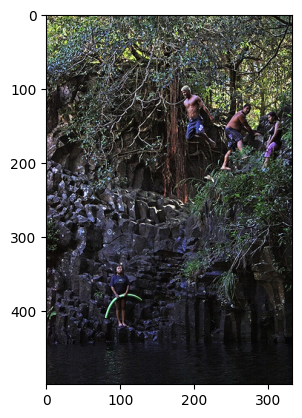



This image is unavailable in your country in compliance with local laws

query:  little brown and white dog run on the sidewalk
prediction:  [0.39757645721142604]


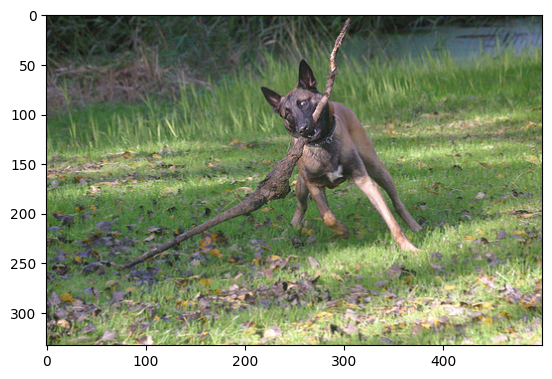



This image is unavailable in your country in compliance with local laws

query:  a man in a blue shirt lift up his tennis racket and smile
prediction:  [0.23573141248961882]


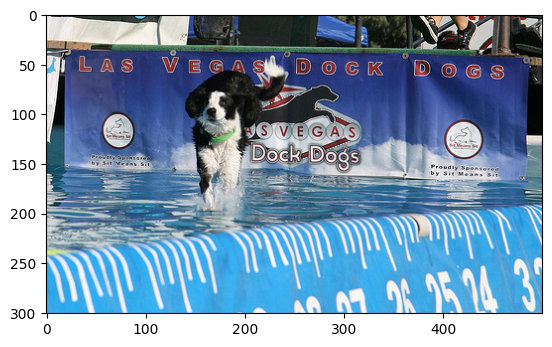



query:  a man in a white hat be stand behind a woman with a red shawl over her head
prediction:  [0.20462677842464497]


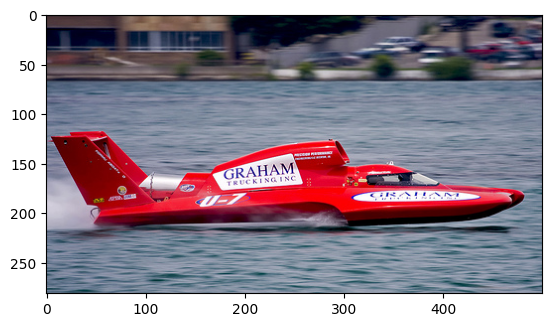



query:  a black and white dog with a chunk of snow it its mouth while walk on a snowy surface
prediction:  [0.33443578139016905]


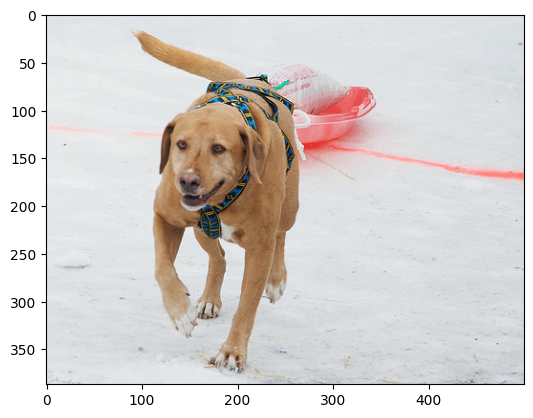

In [ ]:
for sample in samples:
    show_image(sample)

## Выводы

Наша задача заключалась в разработке демонстрационной версии поиска изображения по текстовому запросу.


В нашем распоряжении обучающий и тестовый набор данных с парами «запрос - изображение», в котором каждому изображению соответствует 5 запросов. Также имеются папки с самими изображениями для обучения и тестирования модели.


Нам также предоставлены наборы оценок соответствия запроса изображению, полученные в результате краудсорсинга и опроса экспертов.


Для оценки соответствия мы определили в качестве таргета для краудсорсинговых оценок - доля людей, заявивших о соответствии, для экспертных - суммарное количество полученных от экспертов баллов, деленное на максимально возможную сумму.


В ходе исследования данных мы выяснили, что набор эксперты выставляли оценки для обучающего набора данных. У краудсорсинговых оценок совпадений с обучающим набором только 50%. Поэтому для дальнейшей работы были взяты экспертные оценки.


Помимо этого нам необходимо было учитывать юридические ограничения на показ изображений детей, действующие в некоторых странах. Для этого мы создали черный список слов. Из обучающего набора запросы с такими словами были удалены. В тесте будет выводиться заглушка ⎪ This image is unavailable in your country in compliance with local laws.


Далее с помощью инструментов PyTorch и BERT мы провели векторизацию изображений и текстов.


Для обучения мы взяли модели линейной регрессии, случайного леса, а также полносвязные нейронные сети. В качестве метрики качества взято RMSE. Данные в наборе распределены неравномерно - у нас есть большое количество низких оценок и мало высоких оценок соответствия фотографии описанию. RMSE должен помочь сгладить эти разбросы.


Лучший результат показала модель случайного леса с оценкой 0.07.


С помощью тестовой модели мы показали, что модель выводит не особо релевантные запросу изображения и часто выдает изображения собак. Скорее всего таких изображений было достаточно много в обучающем наборе. Так же как было много изображений не соответствующих или слабо соответствующих описанию. Но зато она выводит изображения, попадающие под юридические ограничения.

Улучшить работу модели можно было бы, например, за счет большего разнообразия изображений, а также увеличения доли изображений, соответствующих запросу.